In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pandas as pd
import re # search in an string

In [2]:
def load_csv(file_path):
    all_snapshots = []
    lines_per_snapshot = 22341 #number of collocations/sensors in a single snapshot
    lines_of_garbage = 6
    lines_per_section = lines_per_snapshot + lines_of_garbage
    column_names = ['p', 'c', 'w', 'k', 'u', 'v', 'x', 'y']
    snapshot_number = 0
    for chunk in pd.read_csv(file_path, 
                             chunksize=lines_per_section,
                             skip_blank_lines=False,
                             names=column_names,
                             delimiter=','):       
        snapshot_number += 1
        chunk['snapshot'] = None
        data_lines = chunk.iloc[lines_of_garbage:].copy()
        if (len(data_lines)==0):break
        print(f"Loading snapshot {snapshot_number}/100, Length: {len(data_lines)}", end='\r', flush=True)
        data_lines['t'] = snapshot_number
        all_snapshots.append(data_lines)
    data = pd.concat(all_snapshots, ignore_index=True)
    
    # data cleaning
    data['c'] = pd.to_numeric(data['c'], errors='coerce')
    data.loc[data['c'] < 0, 'c'] = 0 
#     data['u'] = pd.to_numeric(data['u'], errors='coerce')
#     data['v'] = pd.to_numeric(data['v'], errors='coerce')
#     data['k'] = pd.to_numeric(data['k'], errors='coerce')
#     data['w'] = pd.to_numeric(data['w'], errors='coerce')
#     data['x'] = pd.to_numeric(data['k'], errors='coerce')
#     data['y'] = pd.to_numeric(data['w'], errors='coerce')
#     data['t'] = pd.to_numeric(data['w'], errors='coerce')
    
    
    # add wind and leak_x, leak_y, leak_s to dataset
    [wind, leak_x, leak_y, leak_s] = determine_wind_and_leak(file_path)
    data['wind'] = wind
    data['leak_x'] = leak_x
    data['leak_y'] = leak_y
    data['leak_s'] = leak_s
    return data

In [3]:
def determine_wind_and_leak(file_path):
    leak_s = None
    wind = None
    leak_x = None
    leak_y = None
    file_name = file_path[-8:]

    radius = 40
    # determine free-stream ambient wind speed
    if re.search(r'l[hl]', file_name):
        wind = 6
    elif re.search(r'm[hl]', file_name):
        wind = 9
    elif re.search(r'h[hl]', file_name):
        wind = 12

    # determine leakage speed at the orifice    
    if re.search(r'[lmh]l', file_name):
        leak_s = 0.5
    elif re.search(r'[lmh]h', file_name):
        leak_s = 1.0
    
    # determine leakage location
    if re.search(r'e[lmh][lh]', file_name):
        leak_x = radius
        leak_y = 0
    elif re.search(r'ne[lmh][lh]', file_name):
        leak_x = radius/np.sqrt(2)
        leak_y = radius/np.sqrt(2)
    elif re.search(r'n[lmh][lh]', file_name):
        leak_x = 0
        leak_y = radius
    elif re.search(r'nw[lmh][lh]', file_name):
        leak_x = -radius/np.sqrt(2)
        leak_y = radius/np.sqrt(2)
    elif re.search(r'w[lmh][lh]', file_name):
        leak_x = -radius
        leak_y = 0    
    elif re.search(r'sw[lmh][lh]', file_name):
        leak_x = -radius/np.sqrt(2)
        leak_y = -radius/np.sqrt(2)
    elif re.search(r's[lmh][lh]', file_name):
        leak_x = 0
        leak_y = -radius
    elif re.search(r'se[lmh][lh]', file_name):
        leak_x = radius/np.sqrt(2)
        leak_y = -radius/np.sqrt(2)        

    if wind is None or leak_x is None or leak_y is None or leak_s is None:
            raise ValueError("One or more variables are None")
    return wind, leak_x, leak_y, leak_s

In [4]:
file_path="./nmh.csv"
data=load_csv(file_path)

In [5]:
data.head()

,p,c,w,k,u,v,x,y,snapshot,t,wind,leak_x,leak_y,leak_s
0,-1.45718426e-01,0.0,1.13835706e+03,1.64920509e-01,9.00041199e+00,0.00000000e+00,-2.00000000e+02,-2.00000000e+02,None,1,9,0,40,1.0
1,-1.26740709e-01,0.0,1.90829956e+03,2.78504044e-01,9.00007439e+00,0.00000000e+00,-2.00000000e+02,-1.94594589e+02,None,1,9,0,40,1.0
2,-8.87517929e-02,0.0,2.07943311e+03,3.03750008e-01,9.00000000e+00,0.00000000e+00,-2.00000000e+02,-1.89189194e+02,None,1,9,0,40,1.0
3,-2.96125151e-02,0.0,2.07943311e+03,3.03750038e-01,9.00000000e+00,0.00000000e+00,-2.00000000e+02,-1.83783783e+02,None,1,9,0,40,1.0
4,5.16862199e-02,0.0,2.07943311e+03,3.03750008e-01,9.00000000e+00,0.00000000e+00,-2.00000000e+02,-1.78378372e+02,None,1,9,0,40,1.0


In [6]:
def plot_variable_evolution(df, index, variable='c'):
    # Check if the index is within the valid range
    if not (0 <= index < 22341):
        raise ValueError("Index must be between 0 and 22340")

    # Extracting the variable data for the specific point across all snapshots
    variable_data = df[variable].iloc[index::22341].astype(np.float64)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(variable_data)
    plt.xlabel('Snapshot')
    plt.ylabel(variable)
    plt.title(f'Evolution of {variable} over time at data point {index}')
    plt.grid(True)
    plt.show()

In [7]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2234100 entries, 0 to 2234099
Data columns (total 14 columns):
 #   Column    Dtype  
---  ------    -----  
 0   p         object 
 1   c         float64
 2   w         object 
 3   k         object 
 4   u         object 
 5   v         object 
 6   x         object 
 7   y         object 
 8   snapshot  object 
 9   t         int64  
 10  wind      int64  
 11  leak_x    int64  
 12  leak_y    int64  
 13  leak_s    float64
dtypes: float64(2), int64(4), object(8)
memory usage: 238.6+ MB


In [8]:
# Find the sensor_index for (x_loc, y_loc)
sensor_index = 10000
def find_index(x_loc,y_loc,eps = 5):
    for sensor_i in range(22341):
        x_sensor = float(data.iloc[sensor_i]['x'])
        y_sensor = float(data.iloc[sensor_i]['y'])
        if x_loc-eps< x_sensor and x_sensor < x_loc+eps:
            if y_loc-eps<y_sensor and y_sensor < y_loc + eps:
                return sensor_i

In [9]:
x_loc = 500
y_loc = 180
sensor_index_1 = find_index(x_loc, y_loc)

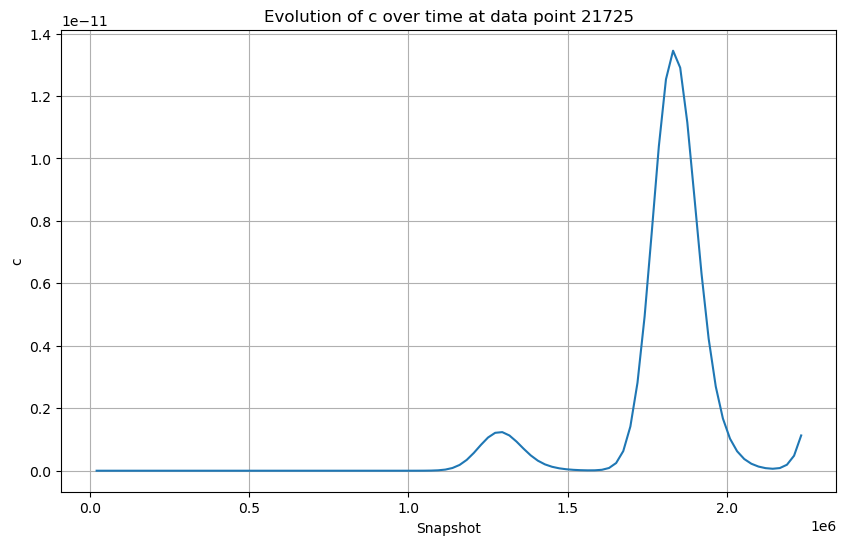

In [10]:
plot_variable_evolution(data, sensor_index_1, variable='c')

In [11]:
def plot_contour(df, snapshot_number, variable='c'):
    # Check if the snapshot number is valid
    if not (1 <= snapshot_number <= 40):
        raise ValueError("Snapshot number must be between 1 and 100")

    # Calculate the row range for the selected snapshot
    start_row = (snapshot_number - 1) * 22341
    end_row = start_row + 22341

    # Extract the snapshot data
    snapshot_data = df.iloc[start_row:end_row]

    # Extract x, y, and c values
    x = snapshot_data['x'].astype(np.float32)
    y = snapshot_data['y'].astype(np.float32)
    c = snapshot_data[variable].astype(np.float32)

    # Create a Triangulation
    triang = tri.Triangulation(x, y)

    # Plotting the contour
    fig, ax = plt.subplots(figsize=(10, 8))
    contour_plot = ax.tricontourf(triang, c, cmap='viridis')

    # Adding a solid circle to mask the contour
    circle_radius=40
    circle = plt.Circle((0, 0), circle_radius, color='white', zorder=10)
    ax.add_artist(circle)
    
    # plot sensor location as an x on the conoutr
    #ax.plot(50, 50, 'rx')
    ax.plot(x_sensor, y_sensor, 'rx')

    # Setting axis limits and labels
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(y), max(y))
    ax.set_aspect('equal', 'box')
    ax.set_title(f'Contour plot of {variable} for snapshot {snapshot_number}')

    # Create a new Axes for the colorbar
    cbar_ax = fig.add_axes([0.93, 0.25, 0.03, 0.5])  # Adjust these values as needed
    cbar = fig.colorbar(contour_plot, cax=cbar_ax)
    cbar.set_label(variable)
    plt.show()

NameError: name 'x_sensor' is not defined

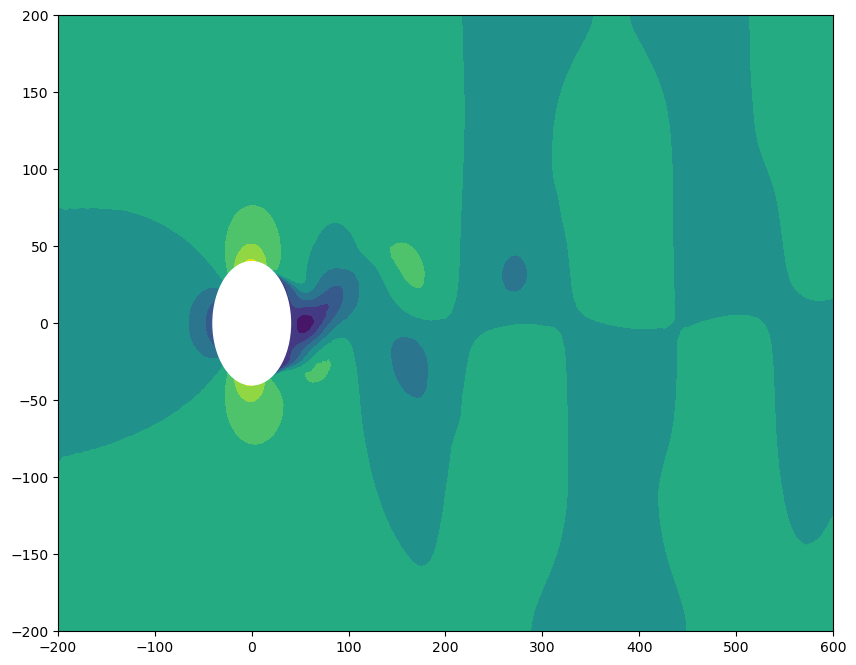

In [12]:
# Example usage
plot_contour(data, 10, 'u')

In [ ]:
data.iloc[1234]['x']